## Import Libraries

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten


## Google Drive connection

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 250
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = dataset_path + '/' + model_name + '.h5'
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history)

def plot_roc_curve(y_true, y_pred, n_classes, class_labels):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model (model, test_dataset):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# create and show confusion matrix and roc
	metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred,display_labels=class_labels, xticks_rotation='vertical')
	plot_roc_curve(y_true, y_score, 4, class_labels)
 
set_seed()


Found 3920 images belonging to 4 classes.
Found 1304 images belonging to 4 classes.
Found 1304 images belonging to 4 classes.


## Load VGG16

In [6]:
# Carica il modello VGG16 pre-addestrato, senza l'ultimo strato fully connected
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                              

## Experiment 1
VGG16 + dense layer 256 neuron

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
123/123 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.6962
Epoch 1: val_loss improved from inf to 0.51494, saving model to /conten

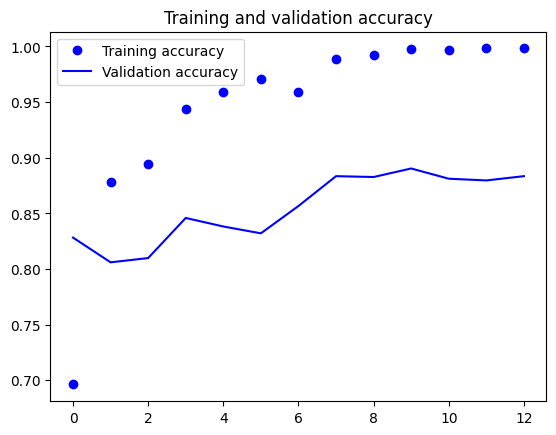

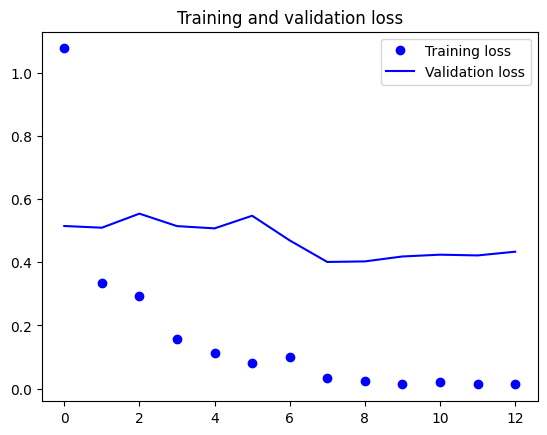

In [7]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16_256")

In [8]:
model = load_model(dataset_path + "/VGG16_256.h5")
# Valuta il modello
evaluate_model(model,test_generator)

25/41 [=================>............] - ETA: 1:47

KeyboardInterrupt: ignored

## Experiment 1
VGG16 + dense layer 512 neuron

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,"VGG16_512")

# Evaluate model
evaluate_model(model,test_generator)

In [ ]:
# unfreeze first block of base_model to make fine tuning